In [1]:
import json

# import gymnasium as gym
import math
import os
import random
import time

import matplotlib as mpl
import numpy as np
from tqdm import trange

# mpl.use('TkAgg')
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# from alg_GLOBALS import *
from alg_plotter import ALGPlotter
from alg_env import FedRLEnv
from alg_nets import CriticNet, ActorNet

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------- # PARAMETERS # -------------------------- #
# M_EPISODE = 10
M_EPISODE = 6400
BATCH_SIZE = 128  # size of the batches
BUFFER_SIZE = 10000
LR = 1e-4  # learning rate
# LR_ACTOR = 1e-3  # learning rate
GAMMA = 0.99  # discount factor
EPSILON_MAX = 0.9
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005  # for soft update of target parameters

# --------------------------- # ENVIRONMENT # -------------------------- #
MAX_STEPS = 38  # 38, 86, 178
SIDE_SIZE = 8  # 8, 16, 32

steps_done = 0
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
episode_durations = []


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


# 动作选取
def select_action(state):
    global steps_done, EPS_START, EPS_END, EPS_DECAY
    sample = random.random()

    # 随着进行，eps_threshold逐渐降低
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    # t_alpha_action = torch.tensor(random.choice(env.action_spaces()['alpha'])).cuda()
    # print(t_alpha_action)
    # exit()
    # 常规情况选择价值最高的动作
    if sample > eps_threshold or 1:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.

            t_alpha_action = policy_net(state).max(1)[1]
            # print(policy_net(state))
            # print(t_alpha_action)
            # print(policy_net(state).max(1))
            # print(policy_net(state).max(1)[0])
            # exit()


    # 当随机值超过阈值时，随机选取 - exploration
    else:
        # return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
        t_alpha_action = torch.tensor(random.choice(env.action_spaces()['alpha'])).cuda()

    # print(t_alpha_action.shape)

    t_beta_action = torch.tensor(random.choices(env.action_spaces()['beta'], k=len(t_alpha_action))).cuda()

    # t_actions = torch.stack((t_alpha_action, t_beta_action))
    # t_actions = zip(*t_actions)

    return t_alpha_action, t_beta_action


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
    # plt.close()


def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    # 离线学习，从记忆池中抽取回忆
    transitions = memory.sample(BATCH_SIZE)
    # print(transitions)
    # exit()

    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.

    # 将([a, 1], [b, 2], [c, 3])转化为([a, b, c], [1, 2, 3])，一个zip的trick
    # 然后将他们分别放到tuples with names里（'state', 'action', 'next_state', and 'reward'）
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    # 计算非最终状态的掩码，并将批处理元素连接起来
    # (最终状态是指模拟结束后的状态)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # print(state_batch.shape)
    # print(action_batch.shape)
    # print(reward_batch.shape)
    # exit()

    # print(action_batch)
    # print(action_batch.shape)
    # 只保留alpha的动作
    # 只根据alpha的动作来计算价值，因为观测不到beta的动作
    action_batch = action_batch[..., 0]
    action_batch = action_batch.unsqueeze(1)
    # print(action_batch)
    # print(action_batch.shape)
    # exit()

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    # 模型计算Q价值，我们根据价值选择动作
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # print(policy_net(state_batch))
    # print(state_action_values)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch  # 当前奖励+下一个状态的奖励，更新Q

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [3]:
ENV_NAME = 'grid'
env = FedRLEnv(max_steps=MAX_STEPS, side_size=SIDE_SIZE)

In [27]:
state = env.reset()
state = state['alpha'].reshape((1, -1))
state = state.cuda()

In [28]:
# 初始化policy_net、target_net
for i_agent in env.agents:
    if i_agent.type == 'alpha':
        policy_net = ActorNet(i_agent.state_size, 4).cuda()
        target_net = ActorNet(i_agent.state_size, 4).cuda()
        target_net.load_state_dict(policy_net.state_dict())

In [29]:
t_alpha_action, t_beta_action = select_action(state)

In [30]:
t_alpha_action

tensor([3], device='cuda:0')

In [31]:
t_beta_action

tensor([0], device='cuda:0')

In [32]:
t_actions = torch.stack((t_alpha_action, t_beta_action)).view(1, -1)

In [55]:
# ACTION: 0,1,2,3 = east > , south v , west < , north ^

In [86]:
t_actions[0][0] = 1
t_actions[0][1] = 2

In [87]:
t_actions

tensor([[1, 2]], device='cuda:0')

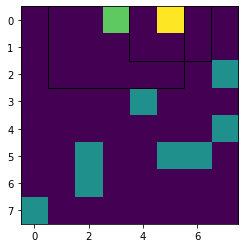

In [88]:
plt.imshow(env.render())

In [89]:
observation, reward, done, _ = env.step(t_actions)

In [90]:
reward

{'alpha': tensor(1.6667, dtype=torch.float64),
 'beta': tensor(1.6667, dtype=torch.float64)}

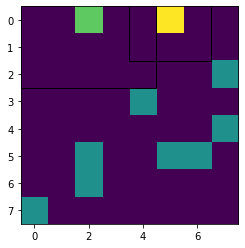

In [91]:
plt.imshow(env.render())

In [92]:
state

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0',
       dtype=torch.float64)

In [93]:
done

False

In [159]:
logs = {
        "train": {
            "rewards": None,
        },
        "eval": {
            "rewards": [],
            "successful": [],
        }
    }

~[INFO]: "ALGPlotter instance created."


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:22<00:00, 35.25it/s]


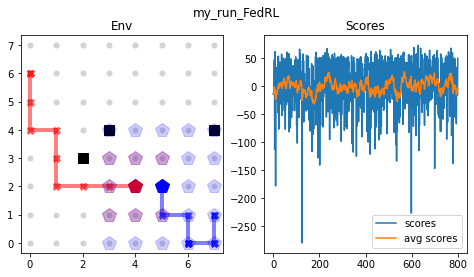

AvgCumulativeReward -0.43377106227106466
SuccessfulRate 0.4375



In [167]:
NEPTUNE = False
PLOT_LIVE = True
plotter = ALGPlotter(plot_life=PLOT_LIVE, plot_neptune=NEPTUNE, name='my_run_FedRL', tags=[ENV_NAME], plot_per=1)
# plotter.neptune_init()

TotalCumulativeReward = []
SuccessfulEpisode = 0
eval_round = 800

for i_eval in trange(eval_round):
    state = env.reset()
    state = state['alpha'].reshape((1, -1))
    # state = state.cuda()
    CumulativeReward = 0
    
    for t in count():
        # t_alpha_action, t_beta_action = select_action(state)
        # t_actions = torch.stack((t_alpha_action, t_beta_action)).view(1, -1)
        # print(t_actions)
        t_actions = torch.rand(2)*4
        t_actions = torch.floor(t_actions.unsqueeze(0))
        # print(t_actions)
        # t_actions.cuda()
        # print(t_actions)
        observation, reward, done, info = env.step(t_actions)
        # observation = observation['alpha'].reshape((1, -1))
        reward = float(reward['alpha'])
        
        CumulativeReward += reward
        if done:
            reward = CumulativeReward
            TotalCumulativeReward.append(reward)
            logs['eval']['rewards'].append(reward)
            if info['success']:
                SuccessfulEpisode += 1
            logs['eval']['successful'].append(info['success'])
            # plotter.plot(i_eval, env, TotalCumulativeReward)
            break

plotter.plot(i_eval, env, TotalCumulativeReward)
# logs['eval']['rewards'] = TotalCumulativeReward

    # with open(folder_name + "/train.txt", 'w') as convert_file:
        # convert_file.write(json.dumps(logs))

print('AvgCumulativeReward', np.sum(TotalCumulativeReward)/eval_round)
print('SuccessfulRate', SuccessfulEpisode / eval_round)
print()

In [164]:
np.sum(TotalCumulativeReward)/800

2.090281524031523

In [152]:
t = 0
for s in logs['eval']['successful']:
    if s == True:
        t+=1
        

In [154]:
t/800

0.43625

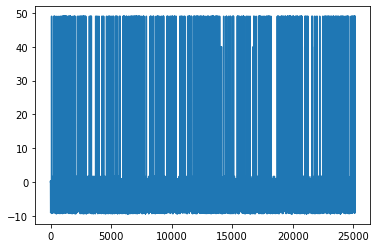

In [158]:
plt.plot(logs['eval']['rewards'])